In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K


In [19]:
img_w, img_h = 1200, 250

num_channels = 3

num_classes = 23

In [20]:
def build_crnn_model(img_w, img_h, num_channels, num_classes):
    input_img = layers.Input(shape=(img_h, img_w, num_channels), name='input_img')

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)  # Немного по-другому уменьшаем размерность
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Conv2D(512, (2, 2), padding='valid', activation='relu')(x)

    conv_shape = K.int_shape(x)
    new_shape = (conv_shape[1], conv_shape[2] * conv_shape[3])

    x = layers.Reshape(target_shape=new_shape)(x)

    x = layers.Dense(64, activation='relu')(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

    y_pred = layers.Dense(num_classes, activation='softmax', name='y_pred')(x)

    return models.Model(inputs=input_img, outputs=y_pred)

In [21]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [22]:
base_model = build_crnn_model(img_w, img_h, num_channels, num_classes)
y_pred = base_model.output

labels = layers.Input(name='labels', shape=[None], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')

loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [y_pred, labels, input_length, label_length]
)

model = models.Model(
    inputs=[base_model.input, labels, input_length, label_length],
    outputs=loss_out
)

model.compile(optimizer='adam', loss={'ctc': lambda y_true, y_pred: y_pred})

In [23]:
csv_path = r"C:\Users\kplot\PyCharmMiscProject\data\annotations.csv"
df = pd.read_csv(csv_path, encoding='cp1251')

image_paths = df["image_path"].tolist()
labels_str = df["label"].tolist()

char_list = "0123456789АВЕКМНОРСТУХ"

char_to_num = {char: i + 1 for i, char in enumerate(char_list)}

def encode_label(label):
    return [char_to_num[ch] for ch in label if ch in char_to_num]

labels_encoded = [encode_label(label) for label in labels_str]

def preprocess_image(img_path):
    try:
        img_data = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img_data, channels=num_channels)
    except Exception as e:
        tf.print("Ошибка при обработке файла", img_path, ":", e)
        raise e
    img.set_shape([None, None, num_channels])
    img = tf.image.resize(img, [img_h, img_w])
    img = tf.cast(img, tf.float32) / 255.0
    return img

print("Пример пути к изображению:", image_paths[:2])
print("Пример исходных меток:", labels_str[:2])
print("Пример кодированных меток:", labels_encoded[:2])

Пример пути к изображению: ['data/images/img1.jpeg', 'data/images/img2.jpeg']
Пример исходных меток: ['B850AK', 'K666EX']
Пример кодированных меток: [[9, 6, 1], [7, 7, 7]]


In [24]:
label_lengths = [len(lbl) for lbl in labels_encoded]

dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels_encoded, label_lengths))

def process_data(img_path, label, label_len):
    image = preprocess_image(img_path)
    label = tf.cast(label, tf.int32)
    input_len = tf.constant([14], dtype=tf.int64)
    label_len = tf.reshape(label_len, [1])
    inputs = {
        'input_img': image,
        'labels': label,
        'input_length': input_len,
        'label_length': label_len
    }
    return inputs, tf.constant(0.0)

dataset = dataset.map(lambda p, l, ll: process_data(p, l, ll),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

batch_size = 2
dataset = dataset.padded_batch(batch_size,
                               padded_shapes=(
                                   {
                                       'input_img': [img_h, img_w, num_channels],
                                       'labels': [None],
                                       'input_length': [1],
                                       'label_length': [1]
                                   },
                                   []
                               ))
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [25]:
model.summary()

epochs = 10
steps_per_epoch = len(image_paths) // batch_size

history = model.fit(dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 250, 1200, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 250, 1200, │      1,792 │ input_img[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 125, 600,  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 125, 600,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 62, 300,   │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 62, 300,   │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 300,   │      1,024 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 62, 300,   │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 31, 300,   │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 31, 300,   │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 300,   │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 31, 300,   │  2,359,808 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 15, 300,   │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 14, 299,   │  1,049,088 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 14,        │          0 │ conv2d_13[0][0]   │
│                     │ 153088)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 14, 64)    │  9,797,696 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 14, 256)   │    197,632 │ dense_1[0][0]     │
│ (Bidirectional)     │                   │            │                 

 Total params: 15,948,503 (60.84 MB)

 Trainable params: 15,946,967 (60.83 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 31.0683
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 18.3621
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 9.1696
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 9.3281
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 8.5680
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 7.7448
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 7.6794
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 7.6205
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 7.3008
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 7.2040


In [26]:
!pip install matplotlib


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


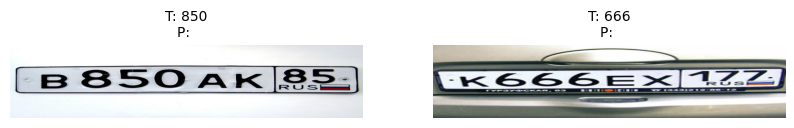

In [27]:
import matplotlib.pyplot as plt

for batch in dataset.take(1):
    inputs, _ = batch
    imgs = inputs["input_img"]
    true_labels = inputs["labels"]

    y_preds = base_model.predict(imgs)
    decoded_preds = K.ctc_decode(y_preds, input_length=tf.constant([14] * len(imgs)), greedy=True)[0][0].numpy()
    num_to_char = {v: k for k, v in char_to_num.items()}

    def decode_prediction(pred):
        return "".join([num_to_char.get(c, "") for c in pred])

    plt.figure(figsize=(10, 5))
    for i in range(len(imgs)):
        plt.subplot(1, len(imgs), i + 1)
        plt.imshow(imgs[i])
        plt.axis("off")
        true_text = decode_prediction(true_labels[i].numpy())
        pred_text = decode_prediction(decoded_preds[i])
        plt.title(f"T: {true_text}\nP: {pred_text}", fontsize=10)
    plt.show()